# Solving the Joint-Sparse BPDN problem using SPORCO

This notebook demonstrates the use of SPORCO to solve the Basis Pursuit DeNoising (BPDN) problem with a joint sparsity-promoting term

$$\mathrm{argmin}_X \; (1/2) \| D X - S \|_2^2 + \lambda \| X \|_1 + \mu \| X \|_{2,1}$$

where $D$ is the dictionary, $X$ is the set of sparse representations, and $S$ is the set of signals to be represented. In this example (based on the ``demo_bpdnjnt.py`` example script) the BPDN problem is used to estimate the reference jointly sparse representations that generated a set of signals from a noisy version of the signals.



Import modules and configure matplotlib output to notebook.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco import util
from sporco import plot
from sporco.admm import bpdn

%matplotlib inline

Configure problem size, sparsity, and noise level.

In [2]:
# Signal and dictionary size
N = 32
M = 4*N
# Number of non-zero coefficients in generator
L = 12
# Number of signals
K = 16;
# Noise level
sigma = 0.5

Construct random dictionary, reference random sparse representation, and test signal consisting of the synthesis of the reference sparse representation with additive Gaussian noise.

In [3]:
# Construct random dictionary and random sparse coefficients
np.random.seed(12345)
D = np.random.randn(N, M)
x0 = np.zeros((M, K))
si = np.random.permutation(list(range(0, M-1)))
x0[si[0:L],:] = np.random.randn(L, K)

# Construct reference and noisy signal
s0 = D.dot(x0)
s = s0 + sigma*np.random.randn(N,K)

Set solver class options for BPDN with joint sparsity promoting term.

In [4]:
# Set BPDNJoint options
opt = bpdn.BPDNJoint.Options({'Verbose' : False, 'MaxMainIter' : 500,
                              'RelStopTol' : 1e-3, 'rho' : 10.0,
                              'AutoRho' : {'RsdlTarget' : 1.0}})

Select regularization parameters $\lambda$ and $\mu$ by evaluating the error in recovering the sparse representation over a logarithmicaly spaced grid. (The reference representation is assumed to be known, which is not realistic in a real application.) A function is defined that evalues the joint-sparse BPDN recovery error for a specified $\lambda, \mu$, and this function is evaluated in parallel by ``sporco.util.grid_search``.

In [5]:
# Function computing reconstruction error for (lmbda, mu) pair
def evalerr(prm):
    lmbda = prm[0]
    mu = prm[1]
    b = bpdn.BPDNJoint(D, s, lmbda, mu, opt)
    x = b.solve()
    return np.sum(np.abs(x-x0))


# Parallel evalution of error function on lmbda,mu grid
lrng = np.logspace(-4, 0.5, 10)
mrng = np.logspace(0.5, 1.6, 10)
sprm, sfvl, fvmx, sidx = util.grid_search(evalerr, (lrng, mrng))
lmbda = sprm[0]
mu = sprm[1]

print('Minimum ℓ1 error: %5.2f at (𝜆,μ) = (%.2e, %.2e)' % (sfvl, lmbda, mu))

Minimum ℓ1 error: 40.36 at (𝜆,μ) = (1.00e-04, 1.71e+01)


Plot recovery error against $\lambda$ and $\mu$.

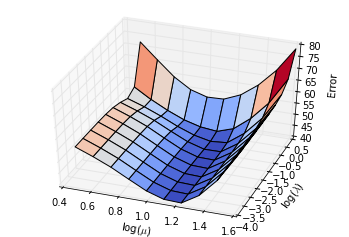

In [6]:
fg = plot.figure()
ax = plot.plt.axes(projection='3d')
ax.view_init(elev=40, azim=-70)
ax.xaxis._axinfo['label']['space_factor'] = 2.0
ax.yaxis._axinfo['label']['space_factor'] = 2.0
ax.zaxis._axinfo['label']['space_factor'] = 2.0
fgax = plot.surf(fvmx, x=np.log10(mrng), y=np.log10(lrng), xlbl='log($\mu$)',
                   ylbl='log($\lambda$)', zlbl='Error', fgrf=fg, axrf=ax)

Once the best $\lambda, \mu$ have been determined, run joint-sparse BPDN with verbose display of ADMM iteration statistics.

In [7]:
# Initialise and run BPDNJoint object for best lmbda and mu
opt['Verbose'] = True
b = bpdn.BPDNJoint(D, s, lmbda, mu, opt)
b.solve()

print("BPDNJoint solve time: %.2fs" % b.timer.elapsed('solve'))

Itn   Fnc       DFid      Regℓ1     Regℓ2,1   r         s         ρ         
--------------------------------------------------------------------------
   0  2.50e+03  2.44e+03  1.08e+01  3.18e+00  9.14e-01  1.43e-01  1.00e+01
   1  1.01e+03  5.79e+02  8.48e+01  2.55e+01  5.50e-01  3.77e-01  1.00e+01
   2  1.20e+03  4.44e+02  1.46e+02  4.39e+01  2.81e-01  3.51e-01  1.00e+01
   3  8.65e+02  1.72e+02  1.35e+02  4.05e+01  1.99e-01  2.26e-01  1.00e+01
   4  7.83e+02  1.76e+02  1.19e+02  3.55e+01  1.51e-01  1.96e-01  1.00e+01
   5  7.74e+02  2.04e+02  1.13e+02  3.33e+01  1.27e-01  1.00e-01  1.00e+01
   6  7.39e+02  1.54e+02  1.16e+02  3.42e+01  9.41e-02  7.47e-02  1.00e+01
   7  7.30e+02  1.08e+02  1.23e+02  3.63e+01  6.86e-02  7.00e-02  1.00e+01
   8  7.27e+02  9.87e+01  1.24e+02  3.67e+01  5.50e-02  4.15e-02  1.00e+01
   9  7.23e+02  1.12e+02  1.20e+02  3.57e+01  4.29e-02  3.56e-02  1.00e+01
  10  7.22e+02  1.21e+02  1.18e+02  3.51e+01  3.34e-02  2.73e-02  1.10e+01
  11  7.20e+02  1.09e+0

Display comparison of reference and recovered representations.

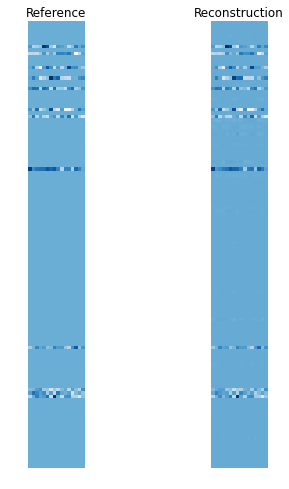

In [8]:
# Display results
fig1 = plot.figure(1, figsize=(6,8))
plot.subplot(1,2,1)
plot.imview(x0, fgrf=fig1, cmap=plot.cm.Blues, title='Reference')
plot.subplot(1,2,2)
fgax = plot.imview(b.Y, fgrf=fig1, cmap=plot.cm.Blues, title='Reconstruction')

Plot functional evolution during ADMM iterations.

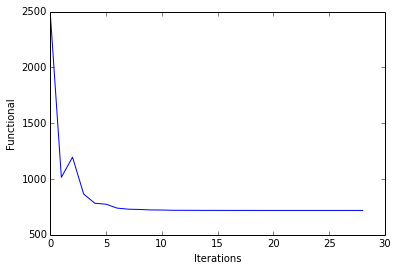

In [9]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')
plot.close()

Plot evolution of ADMM residuals and ADMM penalty parameter.

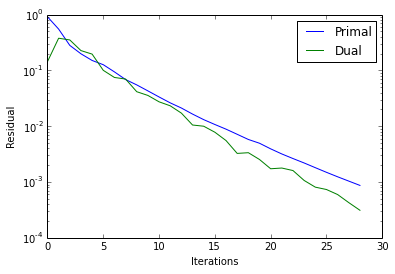

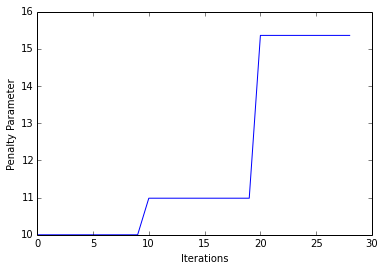

In [10]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, 
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')
plot.close()
